# MovieLens data set
The example we will work on is the MovieLens data set, a common publicly available data set for collaborative filtering. The full data set and information is available here: https://grouplens.org/datasets/movielens/. Although the full MovieLens data set is fairly large, there is a smaller subset available here: http://files.grouplens.org/datasets/movielens/ml-latest-small.zip which we’ll use for this example. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
%matplotlib inline
plt.rcParams['figure.figsize'] = 10,8

# Load the ratings and movie datafiles
- ratings.csv has 100836 rows with columns: userId, movieId, rating and timestamp
- Number of unique users is 610, number of unique movies is 9724, ratings has a rating for each userId,movieId pair where userId rated movieId
- movies.csv has 9742 rows with columns: movieId, title, genres

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Raw ratings dataset shape =  (100836, 4)
Number of unique users =  610
Number of unique movies =  9724


,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


Raw movie names dataset shape =  (9742, 2)
Top 20 genres


Drama                      1053
Comedy                      946
Comedy|Drama                435
Comedy|Romance              363
Drama|Romance               349
Documentary                 339
Comedy|Drama|Romance        276
Drama|Thriller              168
Horror                      167
Horror|Thriller             135
Crime|Drama                 134
Crime|Drama|Thriller        125
Drama|War                   114
Comedy|Crime                101
Action|Comedy                92
Thriller                     84
Children|Comedy              74
Comedy|Horror                69
Action|Crime|Thriller        66
Action|Adventure|Sci-Fi      66
Name: genres, dtype: int64

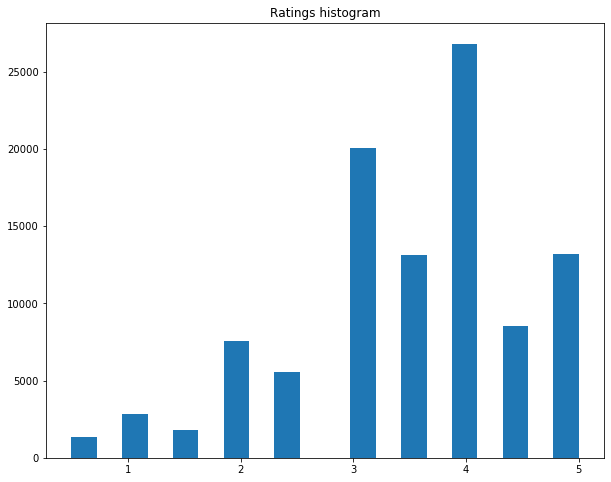

In [4]:
# load MovieLens ratings
datadir = 'ml-latest-small/'
df = pd.read_csv(datadir + "ratings.csv")
display(df.head())
print('Raw ratings dataset shape = ', df.shape)
nusers = len(set(df.userId))
nmovies = len(set(df.movieId))
print('Number of unique users = ', nusers)
print('Number of unique movies = ',nmovies )
plt.hist(df.rating,bins=20)
plt.title('Ratings histogram')

# load movie names and genres
df_mov = pd.read_csv(datadir + "movies.csv", index_col="movieId")
display(df_mov.head())
print('Raw movie names dataset shape = ', df_mov.shape)
print('Top 20 genres')
df_mov.genres.value_counts()[:20]

# How many movies does a user rate?

Min =  20 
Max =  2698 
Mean =  165.30491803278687 
Std =  269.4805843871719


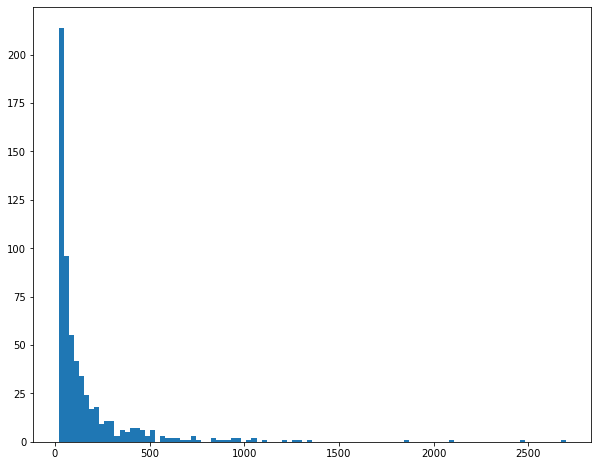

In [5]:
gu = df.groupby('userId')['movieId'].agg('count')
print('Min = ',gu.min(), '\nMax = ', gu.max(), '\nMean = ',gu.mean(), '\nStd = ',gu.std())
plt.hist(gu,bins=100);

# How many users see/rate a  movie?

Min =  1 
Max =  329 
Mean =  10.369806663924312 
Std =  22.401004809608985


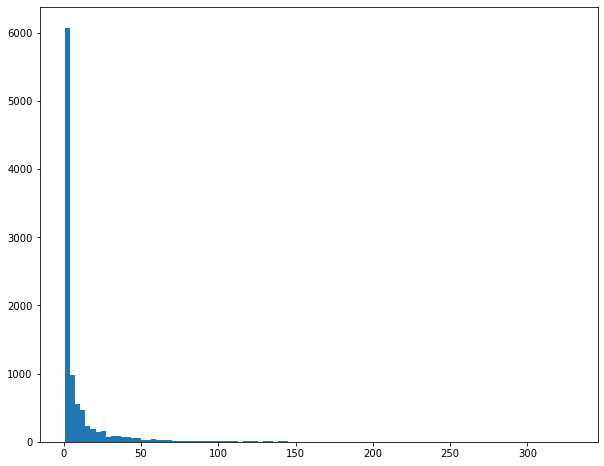

In [6]:
gm = df.groupby('movieId')['userId'].agg('count')
print('Min = ',gm.min(), '\nMax = ', gm.max(), '\nMean = ',gm.mean(), '\nStd = ',gm.std())
plt.hist(gm,bins=100);

# How many unique (userId,movieId) pairs are there?

In [7]:
g1 = df.groupby(['userId','movieId'])['rating'].agg('count')
print("Number of (userId, movieId) pairs = ", g1.shape)
print("Possible number of entries = ", nusers*nmovies)
print("Sparsity of user x movie matrix is = ", g1.shape[0]/(nusers*nmovies) * 100, '%')

Number of (userId, movieId) pairs =  (100836,)
Possible number of entries =  5931640
Sparsity of user x movie matrix is =  1.6999683055613624 %


# Find movies that have 5 or more ratings

In [8]:
gm = df.groupby('movieId')['userId'].agg('count')
valid_movies = list(gm[gm >= 5].index)
print('There are ', len(valid_movies), ' movies that have been viewed 5 or more times.')

There are  3650  movies that have been viewed 5 or more times.


# Clean dataframe df to include movies with 5 or more ratings

In [9]:
# retain rows in df which refer to valid movies
clean_df = df[df['movieId'].isin(valid_movies)]
clean_df.shape

(90274, 4)

# How many distinct users are there?

In [10]:
unique_users = np.unique(df.userId)
print("There are ", unique_users.shape[0], " unique users.")

There are  610  unique users.


# Generating the user x movies matrix

- Note that we’re generating a  matrix of 610 user IDs by 3650 movie IDs, using the pivot_table operation
- While this data set was already filtered to only include users who ranked a reasonable number of movies, we have  filtered it further to only include movies with five or more ratings.
- In the pivot table the NaN entries correspond to unknown elements. (unrated movies) 

In [11]:
user_x_movie = pd.pivot_table(clean_df, values='rating', index=['userId'], columns = ['movieId'])
user_x_movie.sort_index(axis=1, inplace=True)
user_x_movie.shape

(610, 3650)

In [16]:
user_x_movie

movieId,1,2,3,4,5,6,7,8,9,10,...,176371,177593,177765,179401,179819,180031,180985,183897,187593,187595
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
valid_movie_df = pd.DataFrame(np.array(valid_movies),columns=['movieId'])
valid_movie_title_df = pd.merge(valid_movie_df,df_mov,left_on='movieId',right_index=True)
display(valid_movie_title_df.head())
movie_to_title = dict(zip(valid_movie_title_df['movieId'],valid_movie_title_df['title']))
movie_to_title[2]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


'Jumanji (1995)'

# Computing average rating for each user and for each movie

- we can compute per-user and per-item mean ratings from the pivot table.
- np.mean() handles NaNs correctly!

(610,)


userId
1    4.361233
2    3.981481
3    1.482143
4    3.542714
5    3.636364
dtype: float64

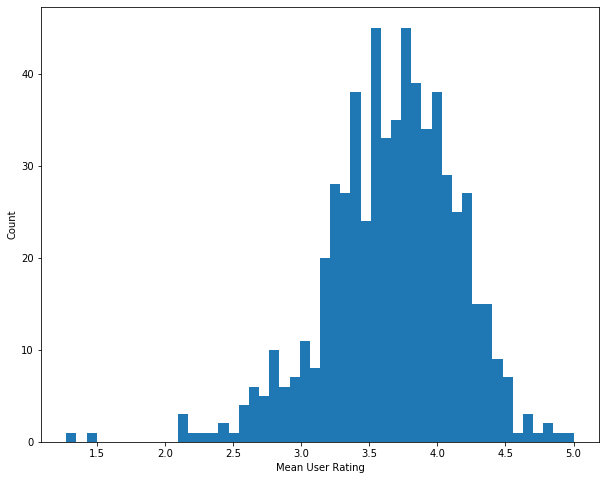

In [13]:
user_means = user_x_movie.mean(axis=1)
print(user_means.shape)
display(user_means.head())
plt.hist(user_means, bins=50)
plt.xlabel("Mean User Rating")
plt.ylabel("Count");

(3650,)


movieId
1    3.920930
2    3.431818
3    3.259615
4    2.357143
5    3.071429
dtype: float64

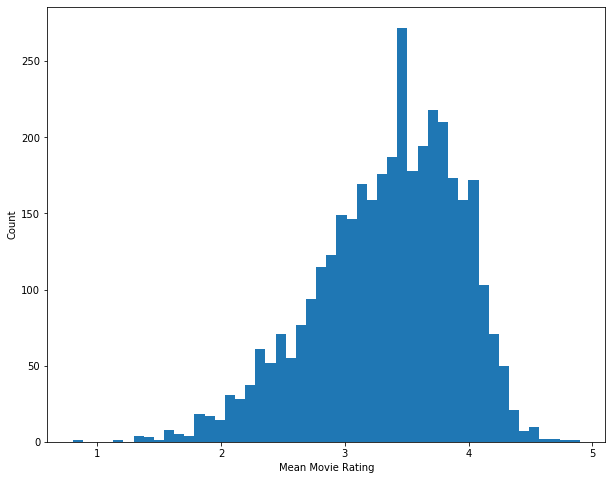

In [14]:
movie_means = user_x_movie.mean(axis=0)
print(movie_means.shape)
display(movie_means.head())
plt.hist(movie_means, bins=50)
plt.xlabel("Mean Movie Rating")
plt.ylabel("Count");

# Top 5 movies and bottom 5 movies by rating
- lets see what the top 5 and bottom 5 movies are in this dataset
- np.argsort() also handles NaNs correctly

In [15]:
top5 = np.argsort(movie_means)[-5:]
bottom5 = np.argsort(movie_means)[:5]
print("Top 5  movies")
display(valid_movie_title_df.loc[top5])
print("Bottom 5 movies")
display(valid_movie_title_df.loc[bottom5])

Top 5  movies


,movieId,title,genres
1973,4334,Yi Yi (2000),Drama
1129,2239,Swept Away (Travolti da un insolito destino ne...,Comedy|Drama
2674,31364,Memories of Murder (Salinui chueok) (2003),Crime|Drama|Mystery|Thriller
3641,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
2338,6460,"Trial, The (Procès, Le) (1962)",Drama


Bottom 5 movies


,movieId,title,genres
2558,8387,Police Academy: Mission to Moscow (1994),Comedy|Crime
2175,5323,Jason X (2002),Horror|Sci-Fi|Thriller
2798,43904,When a Stranger Calls (2006),Horror|Thriller
1403,2799,Problem Child 2 (1991),Comedy
2580,8666,Catwoman (2004),Action|Crime|Fantasy


# Distribution of number of reviews by movies and by users
- we use (user_x_movie > 0) to get the actually rated (user,movie) pairs, since (np.nan > 0) is False.

(3650,)


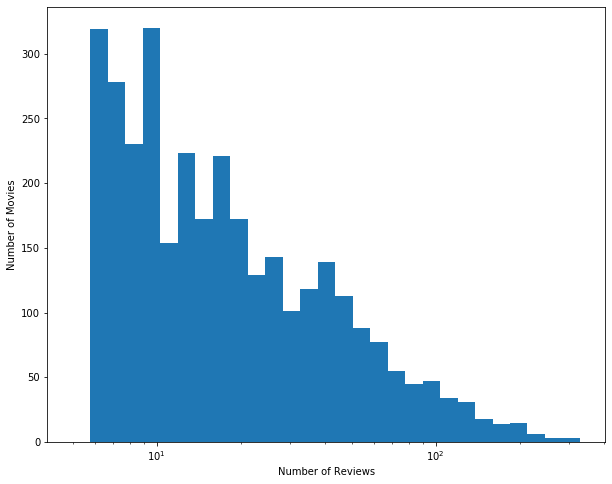

In [16]:
num_reviews = (user_x_movie > 0).astype(float).sum(axis=0)
print(num_reviews.shape)
plt.hist(num_reviews,bins=np.logspace(np.log10(min(num_reviews)),np.log10(max(num_reviews)),30))
plt.gca().set_xscale("log")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Movies");

(610,)


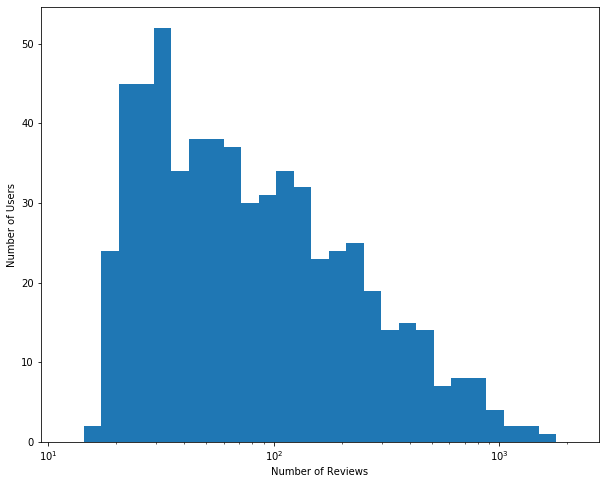

In [17]:
num_reviews = (user_x_movie > 0).astype(float).sum(axis=1)
print(num_reviews.shape)
plt.hist(num_reviews,bins=np.logspace(np.log10(min(num_reviews)),np.log10(max(num_reviews)),30))
plt.gca().set_xscale("log")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Users");

# Types of collaborative filtering algorithms
While there are several possible algorithms for collaborative filtering, broadly speaking most of them fit into one of three different categories:

- User-user approaches: In this approach we estimate a user’s rating of an item by finding “similar” users and then looking at their predictions for this item.
- Item-item approaches: These methods take the converse approach, and estimate a user’s rating of a item by finding similar items and then looking at the user’s rating of these similar items.
- Matrix factorization: Finally, the last class of approaches works a little bit differently, by aiming to construct a low-rank matrix that approximates the observed entries of the rating matrix.

We’ll discuss the first two methods these in turn, and look at how they can be implemented on the MovieLens data set The matrix factorization will be developed further in Lab 7.

# User-user methods
As mentioned above, the key idea of the user-user approach is that in order to predict an unknown user-item score, we’re going to find “similar” users, and then look at how they scored that item. To compute similar users, we can use common techniques like correlation coefficient, cosine_similarity, etc, with the caveat that these metrics typically assume fixed-sized vectors with no unknown elements, so some changes are typically needed to apply to the collaborative filtering setting.

To start, let’s introduce a slightly more formal bit of notation to define our problem. Let $X_{ij}$ denote our prediction for the ith user and jth item (i.e., this will be one of the elements that is missing from the matrix X, which we want to predict). A common form for the prediction make by the user-user approach would be

$$ X_{ij}=\bar{x}_i +\frac{\sum_{k:X_{kj} \neq 0} w_{ik}(X_{kj}−\bar{x}_k)}{\sum_{k:X_{kj} \neq 0}|w_{ik}|}$$
where $\bar{x}_i$ denotes the average of the observed ratings for user i,and $w_{ik}$ denotes a similarity weight between user i and user k (which we will define shortly). The intuition behind this approach is the following: if we want to predict user i’s rating for item j, we look across all users that do have ratings for item j, and we average these together, weighted by a similarity function between the two users (we divide by $\sum{k:X_{kj}\neq 0} |w_{ik}|$) so that we are taking a weighted average, noting that we take the absolute value because similarity weights can sometimes be positive or negative depending how we define them). Because user’s also frequently have their own “baseline” rating (i.e., some users naturally assign lower ratings than others), it’s slightly better to do this modeling in the “difference space”, the difference between a user’s rating and their mean rating, and then add re-scale by adding a user’s mean score.

Let’s see how this works in code. For now, let’s suppose we have all the user/user weights in the $W \in \Re^{m\times m}$ (remember, by our convention there are m users), which we’ll discuss more shortly. But assuming we have these weights, we can make a prediction by the following code.

In [20]:
# first, we need to handle the nans. We will replace them by 0 and mask them out in every computation
# simplifies the implementation of these formulae
cuser_x_movie = user_x_movie.fillna(0)

In [21]:
# X is the cuser_x_movie matrix, 
# W is a user-user similarity matrix, 
# i is the userId index and j is the jth movieId index
# predict X_{ij} from user-user similarity

def predict_user_user(X, W, user_means, i, j):
    """ Return prediction of X_(ij). """
    return user_means.iloc[i] + (np.sum((X.iloc[:,j] - user_means) * (X.iloc[:,j] != 0) * W[i,:]) / 
                            np.sum((X.iloc[:,j] != 0) * np.abs(W[i,:])))

# Test predict_user_user

- Assuming a similarity matrix of all ones, let’s see how the system predicts how first and 10th user in the userId list  would two the first and second movies in the movieId list.

In [22]:
userId_list = list(cuser_x_movie.index)
movieId_list = list(cuser_x_movie.columns)

W = np.ones((cuser_x_movie.shape[0], cuser_x_movie.shape[0]))

print("User: 0 ",  movie_to_title[movieId_list[0]],predict_user_user(cuser_x_movie, W, user_means, 0, 0))
print("User: 10 ", movie_to_title[movieId_list[0]], predict_user_user(cuser_x_movie, W, user_means, 10, 0))
print("User: 0, ", movie_to_title[movieId_list[1]], predict_user_user(cuser_x_movie, W, user_means, 0, 1))
print("User: 10, ", movie_to_title[movieId_list[1]], predict_user_user(cuser_x_movie, W, user_means, 10, 1))

User: 0  Toy Story (1995) 4.660238071170585
User: 10  Toy Story (1995) 4.0731981393814705
User: 0,  Jumanji (1995) 4.285079866408285
User: 10,  Jumanji (1995) 3.6980399346191706


# Vectorizing similarity computation

Since computing predictions one at a time is fairly slow, let’s see how we can form all the predictions for a user simultaneously (note that we add a small constant to the denominator to cover the case where there is no user (with non-zero weight), who has previously rated the item. Note the use of the W[:,np.newaxis] to facilitate broadcasting. Here is how it works:
```
>> a = np.range(4)
>> print(a)
[0,1,2,3]
>> print(a.shape)
(4,)
>> print(a[:,np.newaxis].shape)
(4,1)
>> print(a[:,newaxis])
[[0],
 [1],
 [2],
 [3]]
```

In [28]:
def predict_user_user(X, W, user_means, i):
    """ Return prediction of userId i over all movieIds. """
    return user_means.iloc[i] + (np.sum((X - user_means[:,np.newaxis]) * (X != 0) * W[i,:,np.newaxis], axis=0) / (np.sum((X != 0) * np.abs(W[i,:,np.newaxis]), axis=0) + 1e-12))

array([4.36123348, 5.36123348, 6.36123348, 7.36123348, 8.36123348])

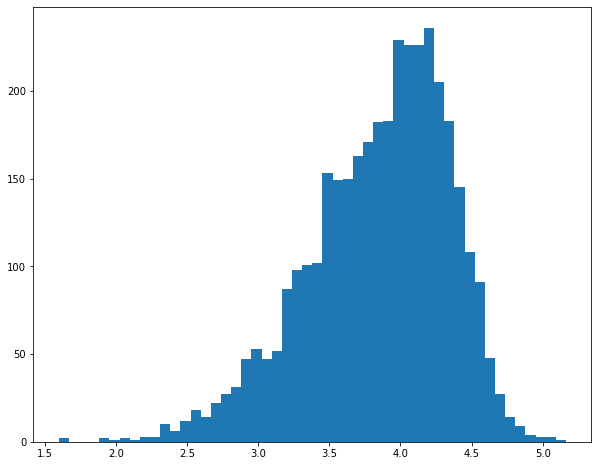

In [29]:
# predictions for userId 1 over all movies
plt.hist(predict_user_user(cuser_x_movie, W, user_means, 1), bins=50);

# Computing similarity weights between users
Of course (since the weights are all equal) we aren’t doing too much here, mainly just computing average scores based upon a user’s mean and the average rating that other reviewers have assigned to a movie. Instead, for this method to be effective, we want to compute a weight matrix that somehow captures the similarity between two users. Because the only information we have in collaborative filtering is based upon the user-item ratings (i.e., we don’t have user-centric features that could be used to compute a similarity between users), the main way that we can build a similarity score is by looking at some kind of correlation between the two sets of ratings; but since two users haven’t necessarily rated the same movies, it is common to compute these correlations only for the set of movies that both have reviewed. We’ll consider a few examples of such weighting schemes.

Pearson correlation Let’s take the standard example of Pearson correlation (one of the most common methods for defining these weights). First, let $I_{ik}$ be the set of movies that user i and user k both rated

$$ I_{ik}=\{j:X_{ij} > 0, X_{kj} > 0\}$$
The Pearson correlation between two users gives the weight

$$ W_{ik}=\frac{\sum_{j\in I_{ik}} (X_{ij}−\bar{x}_i)(X_{kj}−\bar{x}_k)}{\sqrt{\sum_{j \in I_{ik}} {(X_{ij}−\bar{x}_i)}^2} \sqrt{\sum_{j\in I_{ik}}{(X_{kj}−\bar{x}_k)}^2}}$$


which is just the normal Pearson correlation coefficient but only computed over the items where both users rated the item.

The Pearson correlation can be computed via the following function (we add $10^{−12}$ to the denominator to not cause the result to be undefined when the users have no overlap in items).

In numpy @ refers to matrix multiplication (it is called matmul). You can also use np.dot() instead.

In [177]:
aa = np.array([1,2,3,4])
bb = np.array([2,1,1,1])
print(aa)
print(bb)
print(np.dot(aa,bb))

[1 2 3 4]
[2 1 1 1]
11


In [30]:
def pearson(X,user_means, i,k):
    I = np.where((X.iloc[i,:] != 0) & (X.iloc[k,:] != 0))[0]
    xi = X.iloc[i,I] - user_means.iloc[i]
    xk = X.iloc[k,I] - user_means.iloc[k]
    return (xi @ xk)/(np.sqrt((xi @ xi)*(xk @ xk))+1e-12)

pearson(cuser_x_movie,user_means, 0, 1)

0.9999999999577311

# Vectorizing Pearson coefficient computation

However, as before, it’s inefficient to compute these individually for each pair of users. The following function computes the same quantity for all users via the standard matrix vectorization tricks.

0.9999999999999932


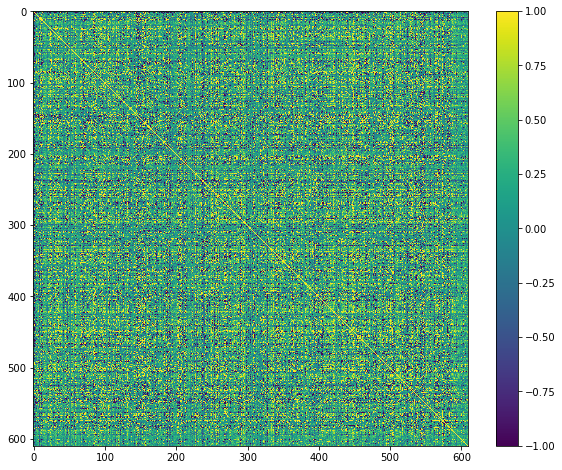

In [31]:
def all_pearson(X,user_means):
    X_norm = (X - user_means[:,np.newaxis])*(X != 0)
    X_col_norm = (X_norm**2)  @ (X_norm != 0).T
    return (X_norm @ X_norm.T)/(np.sqrt(X_col_norm*X_col_norm.T)+1e-12)
W_pearson = all_pearson(cuser_x_movie, user_means)
print(W_pearson.iloc[0][1])
plt.imshow(W_pearson)
plt.colorbar()

In [35]:
def all_pearson(X, user_means, min_common_items=5):
    X_norm = (X - user_means[:,np.newaxis])*(X != 0)
    X_col_norm = (X_norm**2) @ (X_norm != 0).T
    common_items = (X!=0).astype(float) @ (X != 0).T
    return (X_norm @ X_norm.T)/(np.sqrt(X_col_norm*X_col_norm.T)+1e-12) * (common_items >= min_common_items)
W_pearson = all_pearson(cuser_x_movie, user_means)
W_pearson.iloc[0][1]

0.9999999999999932

# Cosine similarity 

The standard cosine similarity is also fairly common to use as a weight, and differs in that (under the usual definition), we don’t subtract off the mean before computing the similarity. It is defined as follows

$$W_{ik}=\frac{\sum_{j=1}^{n} X_{ij}X_{kj}}{ \sqrt{\sum_{j=1}^{n} X_{ij}^2} \sqrt{\sum_{j=1}^{n} X_{kj}^2}} $$
Notice that (again, in the common definition of cosine similarity for collaborative filtering) we also don’t explicitly sum over only the elements where the the user both rated an item. Because we treat missing entries in the matrix as zeros here, these terms won’t factor in to the numerator (any items where both users did not rate an item will be zero), but the denominator is affected by the total number of items each user rated. Thus, if two users both rated a large number of items but their overlap is small, the cosine similarity would be smaller than in the case where they both rated a small number of items that have the number number of overlaping items. Thus, we usually don’t need to explicitly filter for users that have some minimum number of items in common, as we did with Pearson correlation.

The following code will compute the cosine similarity (this time just directly adopting the setting of computing all similarities simultaneously).

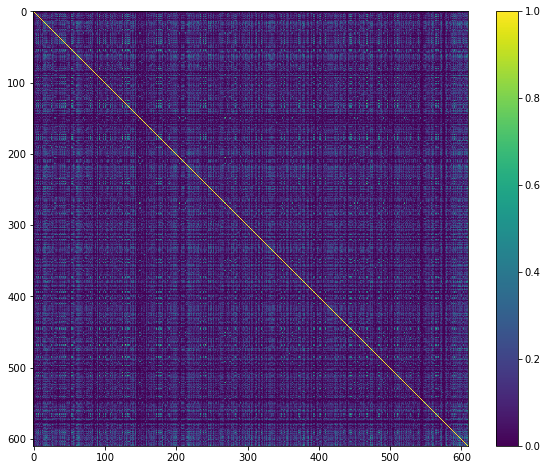

In [33]:
def all_cosine(X):
    x_norm = np.sqrt((X**2).sum(axis=1))
    return (X @ X.T) / np.outer(x_norm, x_norm)
W_cosine = all_cosine(cuser_x_movie)
plt.imshow(W_cosine)
plt.colorbar()

# Nearest neighbors 
After computing one of the above similarity measures (or other similar measures), it’s fairly common to look only at some K users that are most similar to a given user, rather than a sum over all users. This is equivalent to setting the lower entries of W to all be zero, i.e.,

$$\tilde{W}_{ik} = \left \{ \begin{array}{ll}
                         W_{ik} &  {\rm if \; } |W_{ik}| {\rm \; is \; amongst \; top \; K \; values \; for \; user \; i}\\
                         0 & {\rm otherwise}
                         \end{array} \right. $$
Doing so effectively looks just at the most similar users (i.e., the “nearest neighbors”) of user i, instead of all other users. The downside of this approach is that if our data matrix is very sparse, we may not find any other users that have ratings for some new item i, based upon only the neareast neighbors. This could be fixed by considering only those nearest neighbors that do have a given item, but this is computationally more expensive, since we need to recompute neighbors for each item, instead of once per user.

For any existing weight matrix we can limit it to the nearest neightbors with the following function.



In [36]:
def nearest_neighbors(W, K):
    W_neighbors = W.copy()
    W_neighbors[W < np.percentile(np.abs(W), 100-100*K/W.shape[0], axis=0)] = 0
    return W_neighbors
W_pearson_100 = nearest_neighbors(W_pearson, 100)

# Testing nearest neighbors

Because it’s part of the lab (where you implement matrix factorization), we’re not going to rigorously evaluate the performance of the approach, but we can apply the approaches by just plugging in these weights into the functions we considered above.

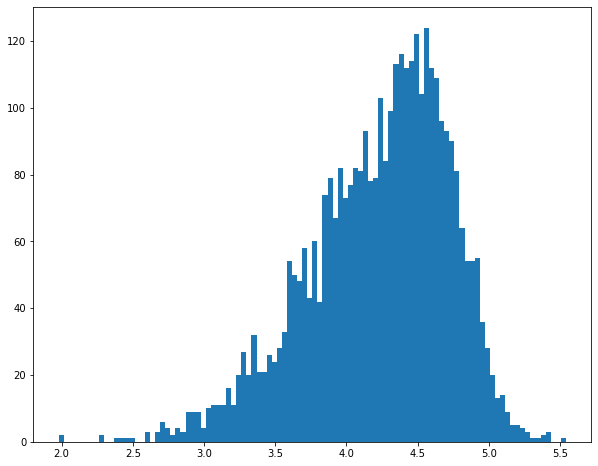

In [37]:
plt.hist(predict_user_user(cuser_x_movie, W, user_means, 0),bins=100);

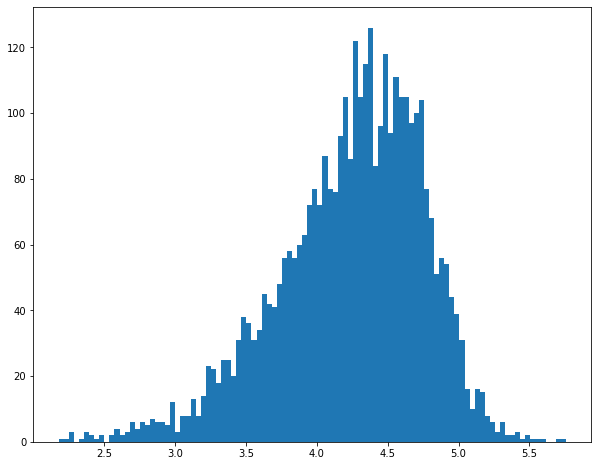

In [38]:
plt.hist(predict_user_user(cuser_x_movie, W_pearson.values, user_means, 0), bins=100);

Using the Pearson correlation produces a great deal more spread in the prediction than in our previous case where we had unit weights. Note that because the weights can be negative, and we’re modeling a difference, it’s completely possible to get ratings outside the allowable range (in practice, we’d simply clip them in this case). Let’s look at the case where we use just the 100 nearest neighbors to make the prediction.

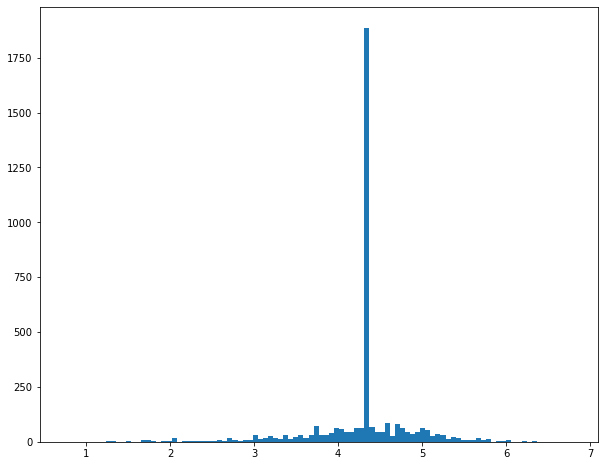

In [39]:
plt.hist(predict_user_user(cuser_x_movie, W_pearson_100.values, user_means, 0), bins=100);

What’s happening here is that if we restrict ourselves to only the 100 nearest neighbors of a given user i, then there are many cases were we don’t have any overlap with the user who predict  for some item, so we make the mean prediction much more (this is intentionally a user for this this is a large difference, other users have less difference, if they happen to have neighbors that rate a more diverse set of items). Finally, let’s look at the cosine similarity-based predictions.

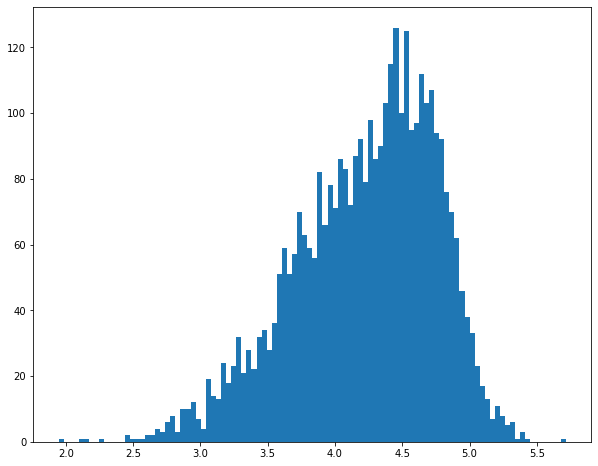

In [40]:
plt.hist(predict_user_user(cuser_x_movie, W_cosine.values, user_means, 0),bins=100);

## Item-item approaches
We’ll mention item-item approaches only very briefly here, because the math is essentially identical to the user-user case, just with the matrices transposed. Whereas the user-user approach was based upon which users were similar to a given user, the item-item approach is based upon what items are similar to a given item. More formally, to make a prediction about the likely rating for user i and item j, we form a weighted combination of the other item ratings that user i has specific, weighted by the similarity between the two items. Formally, this is described by the equation

$$X_{ij}=\bar{x} + \frac{\sum_{k:X_{ik}\neq 0} w_{jk}(X_{ik}−\bar{x}_k)}{\sum_{k:X_{ik} \neq 0}|w_{jk}|} $$
where here $\bar{x}_j$ denotes the average rating for item j (not per-user, as it was before) and $w_{jk}$ denotes the similarity beween item j and item k. Notice that here k sums over other items, not over other users. The weights can be similarly defined by Pearson correlations or cosine similarity, but again here considering the similarity between items instead of users.

One nice this above the approach is that we can reuse all the exact same functions as before, just transposing the relevant matrices.

In [41]:
def predict_item_item(X, W, movie_means, i):
    return predict_user_user(X.T, W, movie_means, i)

W_pearson = all_pearson(cuser_x_movie.T, movie_means)
W_pearson.shape

(3650, 3650)

Note that to get a list of all user predictions, we’d need how to iterate over all items (i.e., form the entire $\hat{X}$ matrix). We can do this slightly more efficiently if desired (i.e., use additional matrix tricks to compute the entire matrix in one operation), but it’s a bit more involved, so we’ll just use the “brute force” approach here (it will take a few minutes to run).

In [42]:
Xhat = np.array([predict_item_item(cuser_x_movie, W_pearson.values, movie_means, i) for i in range(len(movieId_list))]).T

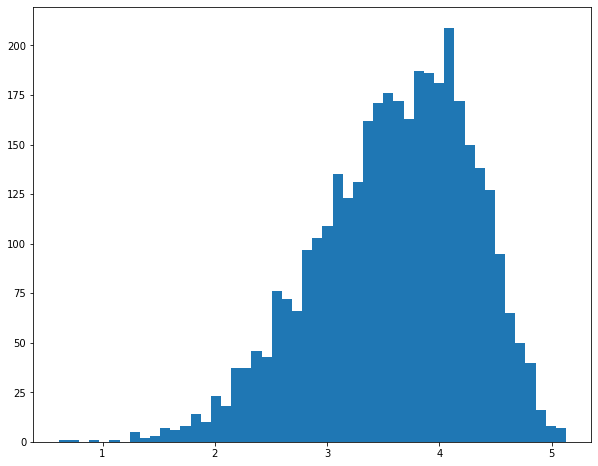

In [44]:
plt.hist(Xhat[0,:], bins=50);

One last element to note, though, is that the similarity matrix W was previously an m×m matrix (number of users by number of users), whereas now it is an n×n matrix. Depending on the number of users and items one of these could be much larger than the other, so one should take this into account regarding memory considerations. Finally, we’ll note that for an actual production system, neither of these matrices would be possible to form directly, so instead it’s more common to just store some set of nearest neighbors for each user/item, rather than the entire matrix.

In [45]:
#plt.hist(Xhat[0,:], bins=50)
Xhat.shape

(610, 3650)